In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from fastai import *
from fastai.vision import *
from torchvision.models import vgg16_bn
from tqdm import tqdm, tqdm_notebook
from crystal_clear.tensor_pipeline import TensorImageList
from fastai.metrics import accuracy

In [3]:
pipeline = 'tensor_pipeline'
path = Path(f'./data/crappified/dataset_1/{pipeline}')
if pipeline == 'tensor_pipeline':
    path_hr = path / 'orig_tensor'
if pipeline == 'image_pipeline':
    path_hr = path / 'orig_spectr'

In [4]:
if pipeline == 'tensor_pipeline':
    meta = pd.read_csv('./data/crappified/dataset_1/meta/meta_tensor.csv')
if pipeline == 'image_pipeline':
    meta = pd.read_csv('./data/crappified/dataset_1/meta/meta_spectr.csv')
meta.subset = meta.subset == 'valid'

In [5]:
meta.head()

,spectr_id,genre,subset
0,2_l_0.ti,Hip-Hop,False
1,2_r_0.ti,Hip-Hop,False
2,2_l_1.ti,Hip-Hop,False
3,2_r_1.ti,Hip-Hop,False
4,2_l_2.ti,Hip-Hop,False


In [6]:
vgg_orig = vgg16_bn(True)

In [12]:
new_head = torch.nn.Sequential(*([torch.nn.Linear(in_features=8192, out_features=4096, bias=True)] + list(vgg_orig.classifier.children())[1:-1] + [torch.nn.Linear(in_features=4096, out_features=8, bias=True)]))
new_head

Sequential(
  (0): Linear(in_features=8192, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)

In [13]:
vgg_orig.classifier = new_head

In [14]:
bs = 32
if pipeline == 'tensor_pipeline':
    data_stats = torch.load(path / 'data_stats.pkl')
    data = TensorImageList.from_df(meta, path_hr).split_from_df('subset').label_from_df('genre').databunch(bs=bs).normalize(data_stats)
if pipeline == 'image_pipeline':
    data_stats = torch.load(path / 'data_stats.pkl')
    data = ImageList.from_df(meta, path_hr).split_from_df('subset').label_from_df('genre').databunch(bs=bs).normalize(data_stats)

In [26]:
learn = Learner(data, vgg_orig, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


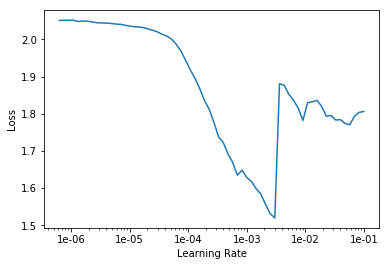

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
max_lr = 1e-3

In [28]:
learn.fit_one_cycle(1,max_lr = max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.615854,0.683248,0.829268,00:20


In [31]:
save_name = 'model_1_fastai'
model_ft = learn.model
torch.save(model_ft, path / 'model_clas' / f'{save_name}.pth')
torch.save(model_ft.state_dict(), path / 'model_clas' / f'{save_name}_weights.pth')